In [1]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.visualization.petrinet import visualizer as pn_vis_factory
from pm4py.objects.petri.exporter.exporter import pnml as pnml_exporter
from graphviz import *

# Log Filtering & Statistics
from pm4py.algo.filtering.log.cases import case_filter
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics

# Conformance checking
from pm4py.evaluation.replay_fitness import evaluator as replay_fitness_evaluator
from pm4py.evaluation.precision import evaluator as precision_evaluator
from pm4py.evaluation.generalization import evaluator as generalization_evaluator
from pm4py.evaluation.simplicity import evaluator as simplicity_evaluator

# Alpha Miner
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

# IMDFb miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

# Heuristics miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner

import utils  # own module with paths and functions

LOAD_REGULAR_LOG = False

In [2]:
if LOAD_REGULAR_LOG:
    log = xes_importer.apply(utils.PATH_LOG)
else:
    log = utils.load_log()  # < 60 s run

In [3]:
df = utils.load_parquet() # < 10 s run

In [4]:
df

,Case ID,Activity,Resource,Complete Timestamp,Variant,Variant index,(case) amount_applied0,(case) amount_applied1,(case) amount_applied2,(case) amount_applied3,...,(case) young farmer,activity,concept:name,docid,doctype,eventid,lifecycle:transition,note,subprocess,success
0,8b99873a6136cfa6,Payment application-Application-mail income,0;n/a,2015/05/08 00:00:00.000,Variant 1832,1832,960.35,NaN,NaN,NaN,...,False,mail income,mail income,-18008611495569447,Payment application,NaN,complete,none,Application,True
1,8b99873a6136cfa6,Payment application-Application-mail valid,0;n/a,2015/05/08 00:00:00.000,Variant 1832,1832,960.35,NaN,NaN,NaN,...,False,mail valid,mail valid,-18008611495569447,Payment application,NaN,complete,none,Application,True
2,8b99873a6136cfa6,Entitlement application-Main-mail valid,0;n/a,2015/05/08 00:00:00.000,Variant 1832,1832,960.35,NaN,NaN,NaN,...,False,mail valid,mail valid,-18008615298673397,Entitlement application,NaN,complete,none,Main,True
3,8b99873a6136cfa6,Entitlement application-Main-mail valid,0;n/a,2015/05/08 00:00:00.000,Variant 1832,1832,960.35,NaN,NaN,NaN,...,False,mail valid,mail valid,-18008615298673397,Entitlement application,NaN,complete,none,Main,True
4,8b99873a6136cfa6,Parcel document-Main-initialize,fb5fa8,2015/06/10 11:16:28.000,Variant 1832,1832,960.35,NaN,NaN,NaN,...,False,initialize,initialize,-72051858488795160,Parcel document,-7.205186e+16,complete,none,Main,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514261,ad5dfa0b929735be,Payment application-Application-decide,155add,2017/12/11 10:26:39.692,Variant 28923,28923,5117.97,NaN,NaN,NaN,...,False,decide,decide,-54037160734808716,Payment application,-9.006594e+16,complete,automatic,Application,True
2514262,ad5dfa0b929735be,Payment application-Application-begin payment,DP-Z,2017/12/15 16:00:12.252,Variant 28923,28923,5117.97,NaN,NaN,NaN,...,False,begin payment,begin payment,-54037160734808716,Payment application,-9.006594e+16,complete,automatic during payment,Application,True
2514263,ad5dfa0b929735be,Payment application-Application-insert document,Notification automaton,2017/12/15 19:19:04.499,Variant 28923,28923,5117.97,NaN,NaN,NaN,...,False,insert document,insert document,-54037160734808716,Payment application,-9.006594e+16,complete,notification for applicant,Application,True
2514264,ad5dfa0b929735be,Payment application-Application-insert document,Notification automaton,2017/12/20 09:02:30.380,Variant 28923,28923,5117.97,NaN,NaN,NaN,...,False,insert document,insert document,-54037160734808716,Payment application,-1.260947e+17,complete,notification for applicant,Application,False


## [Work in progress] Explore and filter log files
link: http://pm4py.pads.rwth-aachen.de/documentation/filtering-logs/

    print(log[0]) #prints the first trace of the log
    print(log[0][0]) #prints the first event of the first trace

### Nr of traces

In [11]:
print(f"Nr of traces: {len(log)}")

Nr of traces: 43809


### Nr of events per trace

In [12]:
nr_events_per_trace = df['Case ID'].value_counts()
nr_events_per_trace[:5]

93deb55be9aed2be    2973
22b697e259a77e16    2490
00101d737b58ff45     907
6dcac1562d4ca766     864
f8ad3caa0d29795c     788
Name: Case ID, dtype: int64

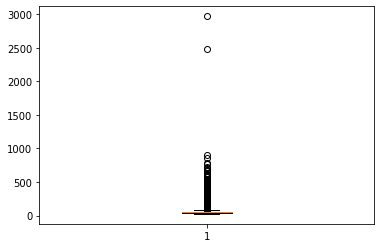

In [13]:
plt.boxplot(nr_events_per_trace);

2 big outliers concerning nr of cases

In [42]:
df.groupby('Case ID')['Complete Timestamp'].max()

Case ID
0002505cb62792e4    2017/08/03 15:54:21.311
0002a55a6130cec8    2016/02/18 07:41:46.343
0004ff62053a60ce    2016/08/19 11:56:47.000
000612b48d30de74    2016/09/14 11:47:48.425
0006cc909ce508b0    2017/06/15 09:24:55.000
                             ...           
fffa80507910b904    2018/01/05 15:25:41.309
fffa93db29ee0841    2017/01/06 15:11:32.944
fffab10d958a3e4d    2017/01/06 14:12:05.156
fffabee101da7ecb    2018/01/05 15:05:15.215
fffadf8d083df3d5    2017/04/25 14:07:21.285
Name: Complete Timestamp, Length: 43809, dtype: object

In [15]:
max_per_case = df.groupby('Case ID')['Complete Timestamp'].apply(max)
min_per_case = df.groupby('Case ID')['Complete Timestamp'].apply(min)

In [19]:
max_per_case

Case ID
0002505cb62792e4    2017/08/03 15:54:21.311
0002a55a6130cec8    2016/02/18 07:41:46.343
0004ff62053a60ce    2016/08/19 11:56:47.000
000612b48d30de74    2016/09/14 11:47:48.425
0006cc909ce508b0    2017/06/15 09:24:55.000
                             ...           
fffa80507910b904    2018/01/05 15:25:41.309
fffa93db29ee0841    2017/01/06 15:11:32.944
fffab10d958a3e4d    2017/01/06 14:12:05.156
fffabee101da7ecb    2018/01/05 15:05:15.215
fffadf8d083df3d5    2017/04/25 14:07:21.285
Name: Complete Timestamp, Length: 43809, dtype: object

In [28]:
time_df = pd.DataFrame({
    'max': max_per_case,
    'min': min_per_case,
}, index=max_per_case.index)
time_df

,max,min
Case ID,,
0002505cb62792e4,2017/08/03 15:54:21.311,2015/04/28 00:00:00.000
0002a55a6130cec8,2016/02/18 07:41:46.343,2015/04/17 00:00:00.000
0004ff62053a60ce,2016/08/19 11:56:47.000,2015/05/11 00:00:00.000
000612b48d30de74,2016/09/14 11:47:48.425,2015/05/06 00:00:00.000
0006cc909ce508b0,2017/06/15 09:24:55.000,2016/04/28 00:00:00.000
...,...,...
fffa80507910b904,2018/01/05 15:25:41.309,2017/05/10 00:00:00.000
fffa93db29ee0841,2017/01/06 15:11:32.944,2016/05/12 00:00:00.000
fffab10d958a3e4d,2017/01/06 14:12:05.156,2016/05/11 00:00:00.000


In [44]:
time_df.dtypes

max    object
min    object
dtype: object

### Extra

In [ ]:
#traces_total = len(log.traces)
variants_count = case_statistics.get_variant_statistics(log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)
# print(variants_count)

In [ ]:
filtered_log = case_filter.filter_on_case_performance(log, 12, 8640000)

In [ ]:
filtered_log